In [866]:
import pandas as pd
dataset = pd.read_csv(r'C:\Users\mtsil\Desktop\german_essays.csv', encoding='unicode_escape')

In [867]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dataset.head(2)

,rater,thema,i_1,i_2,i_3,i_4,t_1,t_2,t_3,sr_1,sr_2,sr_3,sr_4,sa_1,sa_2,sa_3,sa_4,id_text,wle_dsch,sewle_dsch,punkte_dsch,sumscore,essay
0,9,1,2,2,1,1,0,2,1,2,1,2,2,2,2,1,2,K011_001,0.450426,0.551269,822.0,23,"Ich möchte gern in Spanien wohnen, am besten i..."
1,9,1,2,2,1,2,1,2,2,2,1,3,2,2,2,1,2,K011_002,1.651275,0.553108,916.0,27,Ich würde gerne in einem Haus leben. Es sollte...


In [868]:
# create df1 to store the essay variable

df1 = dataset['essay']

In [869]:
# add the values of the style criterion across each row; the sum score is stored in the df2 pandas data frame
# for example, essay 1 has been assessed with the score 7 for its style

pd.set_option('display.max_rows', None)
df2 = dataset[['sa_1', 'sa_2', 'sa_3', 'sa_4']].agg(['sum'], axis=1)
df2.head(2)

,sum
0,7
1,7


In [870]:
# concatenate df1 and df2 into a new pandas data frame called style
# the last three rows do not contain any values for the essay variable

style = pd.concat([df1, df2], axis=1)
style.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",7
1,Ich würde gerne in einem Haus leben. Es sollte...,7


In [871]:
# drop the last three rows and create the final pandas data frame called final_style

final_style = style.drop([125, 126, 127])
final_style.shape

(125, 2)

In [872]:
# check the distribution of the values for the style criterion

final_style[['sum']].value_counts()

sum
7      41
6      38
5      22
8      10
4       9
3       4
2       1
Name: count, dtype: int64

In [874]:
from sklearn.preprocessing import KBinsDiscretizer
# K-Means Discretization
kmean_discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
final_style['sum'] = kmean_discretizer.fit_transform(final_style[['sum']])

final_style.head(2)

c:\users\mtsil\appdata\local\programs\python\python39\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",2.0
1,Ich würde gerne in einem Haus leben. Es sollte...,2.0


In [875]:
final_style['sum'] = final_style['sum'].astype(int)
final_style.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",2
1,Ich würde gerne in einem Haus leben. Es sollte...,2


In [847]:
final_style['sum'].value_counts(ascending = True)

sum
0    14
1    22
2    38
3    51
Name: count, dtype: int64

In [848]:
X = final_style['essay']
y = final_style['sum']

In [850]:
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 6000)
X = td.fit_transform(X).toarray()

In [851]:
# no need for the parameter test_size becauseone-third of the data it is set aside as test data, known as the out-of-bag (oob) sample 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     random_state=0, 
                                                    shuffle=True)

In [854]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))


In [855]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, class_weight= class_weights, max_features = 'log2', min_samples_split = 3, min_samples_leaf = 10, random_state=42, n_jobs=-1)
model.fit(X_train,y_train)



RandomForestClassifier(class_weight={0: 2.1136363636363638,
                                     1: 1.2916666666666667,
                                     2: 0.8611111111111112,
                                     3: 0.6283783783783784},
                       max_features='log2', min_samples_leaf=10,
                       min_samples_split=3, n_jobs=-1, random_state=42)

In [856]:
predictions = model.predict(X_test)

In [857]:
from sklearn.metrics import accuracy_score


In [858]:
print(f'Training set accuracy: {model.score(X_train, y_train):.4f}')
print(f'Test set accuracy: {model.score(X_test, y_test):.4f}')

Training set accuracy: 0.6344
Test set accuracy: 0.5938


In [859]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.67      0.50      0.57         4
           2       0.56      0.45      0.50        11
           3       0.67      0.71      0.69        14

    accuracy                           0.59        32
   macro avg       0.57      0.58      0.57        32
weighted avg       0.60      0.59      0.59        32



In [860]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,predictions)


<Axes: >

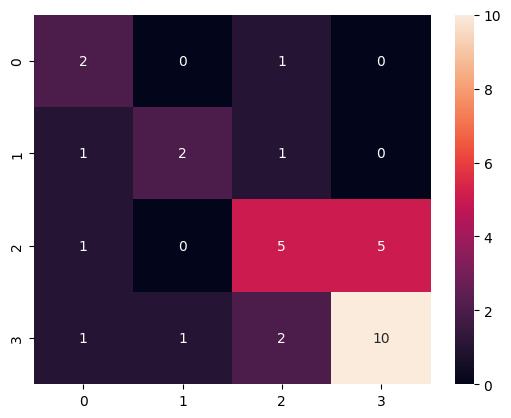

In [861]:
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='.2g')

It seems that the model struggled classifying class 3 and class 4 correctly since it misclassifies instances of class 3 for class 4. 5 instances were incorrectly predicted to belong to class 4. 
Overall, the model did well with class 4.

In [862]:
from sklearn.metrics import roc_auc_score


y_preb_probs = model.predict_proba(X_test)

roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

0.6716440886699508

In [863]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, predictions)

0.39534883720930236